# Fashion-MNIST Classification Project
# 24S2-SC4001 CE/CZ4042: Neural Networks and Deep Learning

## 1. Import Required Libraries and Dependencies

In [1]:
# Import Required Libraries and Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## 2. Configure Device and Paths

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import os
import torch
import requests
import io
import gzip
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# GitHub URLs for the Fashion-MNIST dataset
github_urls = {
    'train_images': "https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/train-images-idx3-ubyte.gz?raw=true",
    'train_labels': "https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/train-labels-idx1-ubyte.gz?raw=true",
    'test_images': "https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/t10k-images-idx3-ubyte.gz?raw=true",
    'test_labels': "https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/t10k-labels-idx1-ubyte.gz?raw=true"
}

# Function to download data from a URL
def download_from_url(url):
    """Download data from a URL and return as bytes"""
    try:
        print(f"Downloading from {url}...")
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Download successful: {url}")
            return response.content
        else:
            print(f"Failed to download from {url}, status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error downloading from {url}: {e}")
        return None

# Function to load MNIST format data from a gzipped byte stream
def load_mnist_from_bytes(images_bytes, labels_bytes):
    """Load MNIST format images and labels from byte streams."""
    
    # Read images
    with gzip.GzipFile(fileobj=io.BytesIO(images_bytes)) as f:
        # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
        images = np.frombuffer(f.read(), 'B', offset=16)
        images = images.reshape(-1, 28, 28).astype(np.float32) / 255.0
    
    # Read labels
    with gzip.GzipFile(fileobj=io.BytesIO(labels_bytes)) as f:
        # First 8 bytes are magic_number, n_labels
        labels = np.frombuffer(f.read(), 'B', offset=8)
    
    return images, labels

# Function to load Fashion-MNIST dataset
def load_fashion_mnist(use_github=True, data_dir='./data'):
    """
    Load Fashion-MNIST dataset, trying GitHub first and falling back to torchvision.
    
    Args:
        use_github: If True, try to download from GitHub
        data_dir: Directory to store the dataset if downloaded via torchvision
    
    Returns:
        train_dataset, test_dataset
    """
    # Try GitHub first if requested
    if use_github:
        try:
            print("Attempting to download Fashion-MNIST from GitHub...")
            
            # Download files from GitHub
            train_images_bytes = download_from_url(github_urls['train_images'])
            train_labels_bytes = download_from_url(github_urls['train_labels'])
            test_images_bytes = download_from_url(github_urls['test_images'])
            test_labels_bytes = download_from_url(github_urls['test_labels'])
            
            # Check if all downloads were successful
            if all([train_images_bytes, train_labels_bytes, test_images_bytes, test_labels_bytes]):
                # Load data from byte streams
                train_images, train_labels = load_mnist_from_bytes(train_images_bytes, train_labels_bytes)
                test_images, test_labels = load_mnist_from_bytes(test_images_bytes, test_labels_bytes)
                
                # Convert to PyTorch tensors and create datasets
                train_images_tensor = torch.tensor(train_images).unsqueeze(1)  # Add channel dimension
                train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
                train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
                
                test_images_tensor = torch.tensor(test_images).unsqueeze(1)  # Add channel dimension
                test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
                test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
                
                print("Successfully loaded Fashion-MNIST from GitHub.")
                return train_dataset, test_dataset
            else:
                print("Some files failed to download from GitHub.")
                use_github = False
                
        except Exception as e:
            print(f"Error loading from GitHub: {e}")
            use_github = False
    
    # Fallback to torchvision
    print("Loading Fashion-MNIST using torchvision...")
    
    # Use torchvision's built-in functionality
    train_dataset = datasets.FashionMNIST(
        root=data_dir, 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = datasets.FashionMNIST(
        root=data_dir, 
        train=False, 
        download=True, 
        transform=transform
    )
    
    print("Successfully loaded Fashion-MNIST using torchvision.")
    return train_dataset, test_dataset

# Load the datasets
train_dataset, test_dataset = load_fashion_mnist(
    use_github=True,  # Try GitHub first
    data_dir='./data'  # For torchvision fallback
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cpu
Attempting to download Fashion-MNIST from GitHub...
Download successful: https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/train-images-idx3-ubyte.gz?raw=true
Download successful: https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/train-labels-idx1-ubyte.gz?raw=true
Download successful: https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/t10k-images-idx3-ubyte.gz?raw=true
Download successful: https://github.com/benjaminyjr17/24S2-SC4001-Fashion-MNIST-Classification/blob/d5d78b36c91724fb63e633c45fa8b5a828939a0c/t10k-labels-idx1-ubyte.gz?raw=true
Successfully loaded Fashion-MNIST from GitHub.
Training dataset size: 60000
Test dataset size: 10000


## 3. Data Loading and Preprocessing

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the datasets is already handled in Cell 2
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Data loaders already created in Cell 2
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training dataset size: 60000
Test dataset size: 10000
Number of training batches: 938
Number of test batches: 157


## 4. Explore and Visualize the Dataset

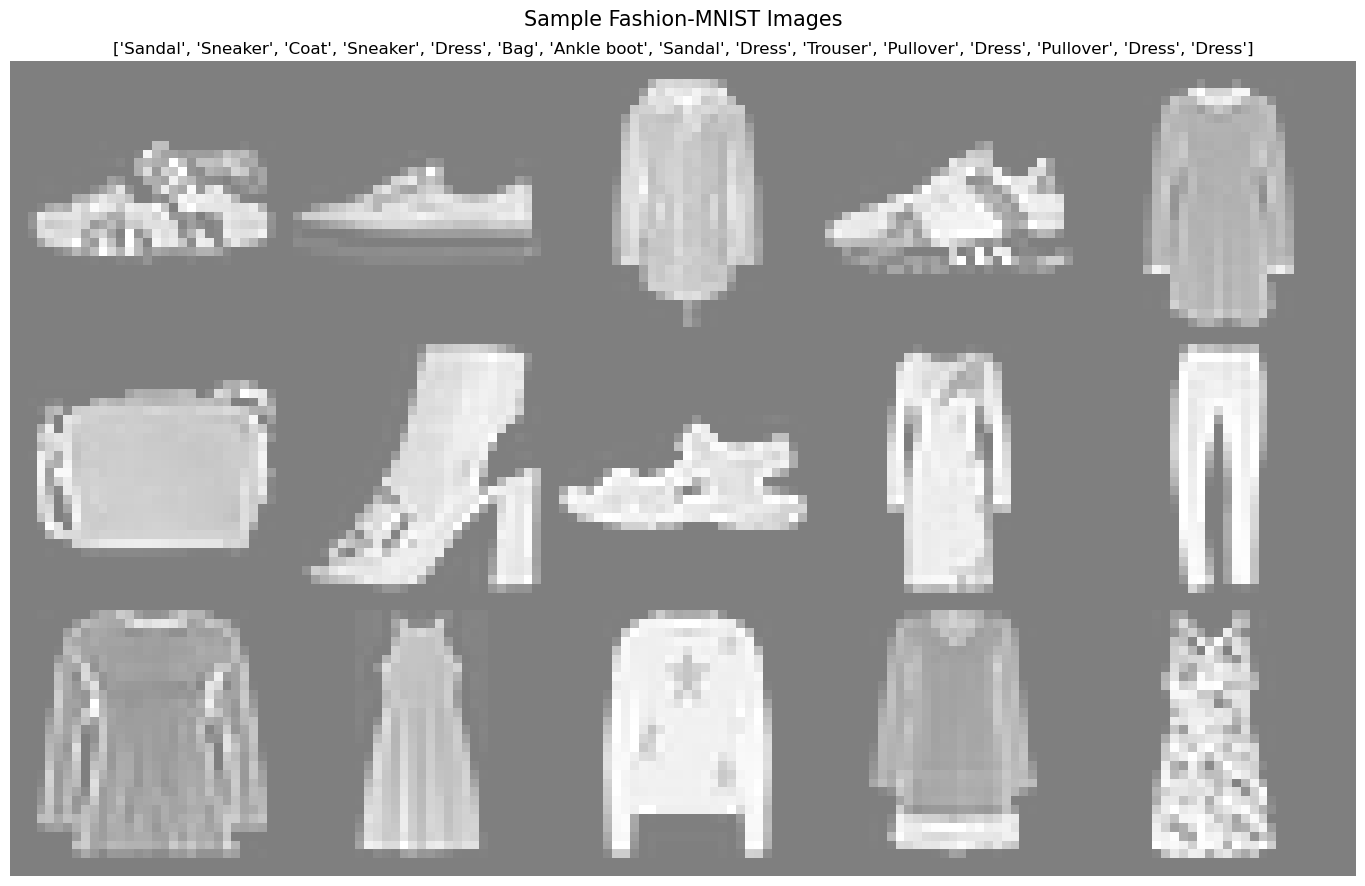

In [4]:
# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to show images
def show_images(images, labels, grid_size=(3, 5), figsize=(15, 9), title=None):
    """Display a grid of images with their labels."""
    plt.figure(figsize=figsize)
    images = images.cpu()  # Move to CPU if they're on GPU
    grid = make_grid(images, nrow=grid_size[1])
    np_grid = grid.numpy().transpose((1, 2, 0))
    
    # Show the grid
    plt.imshow(np_grid * 0.5 + 0.5)  # Denormalize from [-1, 1] to [0, 1]
    plt.axis('off')
    
    # Show the labels
    if labels is not None:
        labels = labels.tolist()
        plt.title([class_names[label] for label in labels], fontsize=12)
    
    if title:
        plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a batch of images
show_images(images[:15], labels[:15], title="Sample Fashion-MNIST Images")

## 5. Define Evaluation Metrics and Utilities

In [ ]:
# Function to calculate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model performance on a dataset."""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    epoch_loss = total_loss / len(dataloader.dataset)
    epoch_acc = total_correct.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc.item(), all_preds, all_labels

# Function to visualize training history
def plot_training_history(train_losses, val_losses, train_accs, val_accs, title="Training History"):
    """Plot training and validation losses and accuracies."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracies (now on the left)
    ax1.plot(train_accs, label='Training Accuracy')
    ax1.plot(val_accs, label='Validation Accuracy')
    ax1.set_title('Accuracy Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot losses (now on the right)
    ax2.plot(train_losses, label='Training Loss')
    ax2.plot(val_losses, label='Validation Loss')
    ax2.set_title('Loss Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(10, 8)):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Calculate classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

# Function to train a model
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Train a model and return training history."""
    # Initialize lists to track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Update progress bar
            train_pbar.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Validation phase
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)
        train_accs.append(epoch_train_acc.item())
        val_accs.append(val_acc)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 40)
        
        # Deep copy the model if best accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return the trained model and history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_acc': best_acc
    }
    
    return model, history


## 6. Model #1: Baseline CNN Implementation

In [6]:
class BaselineCNN(nn.Module):
    """
    Simple CNN baseline model for Fashion-MNIST.
    Architecture:
    - Conv1: 3x3 kernels, 32 filters
    - Conv2: 3x3 kernels, 64 filters
    - MaxPool: 2x2
    - Conv3: 3x3 kernels, 128 filters
    - MaxPool: 2x2
    - Fully Connected: 2048 -> 10
    """
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate output size after convolutions and pooling
        # Initial size: 28x28 -> After conv1&2 and pool1: 14x14 -> After conv3 and pool2: 7x7
        # So final feature map size is 7x7 with 128 channels
        self.fc = nn.Linear(7 * 7 * 128, 10)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Flatten and pass through fully connected layer
        x = x.view(-1, 7 * 7 * 128)
        x = self.fc(x)
        return x
    
    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 7. Train the Baseline CNN Model

Baseline CNN Parameters: 155,850


Epoch 1/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.3926, Train Acc: 0.8644
Val Loss: 0.2964, Val Acc: 0.8951
----------------------------------------


Epoch 2/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.2478, Train Acc: 0.9116
Val Loss: 0.2358, Val Acc: 0.9162
----------------------------------------


Epoch 3/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.2016, Train Acc: 0.9288
Val Loss: 0.2226, Val Acc: 0.9237
----------------------------------------


Epoch 4/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.1696, Train Acc: 0.9382
Val Loss: 0.2309, Val Acc: 0.9187
----------------------------------------


Epoch 5/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.1436, Train Acc: 0.9484
Val Loss: 0.2236, Val Acc: 0.9237
----------------------------------------


Epoch 6/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.1203, Train Acc: 0.9568
Val Loss: 0.2181, Val Acc: 0.9247
----------------------------------------


Epoch 7/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.0987, Train Acc: 0.9644
Val Loss: 0.2318, Val Acc: 0.9269
----------------------------------------


Epoch 8/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.0788, Train Acc: 0.9719
Val Loss: 0.2501, Val Acc: 0.9217
----------------------------------------


Epoch 9/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.0634, Train Acc: 0.9777
Val Loss: 0.2678, Val Acc: 0.9189
----------------------------------------


Epoch 10/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.0527, Train Acc: 0.9820
Val Loss: 0.2775, Val Acc: 0.9228
----------------------------------------


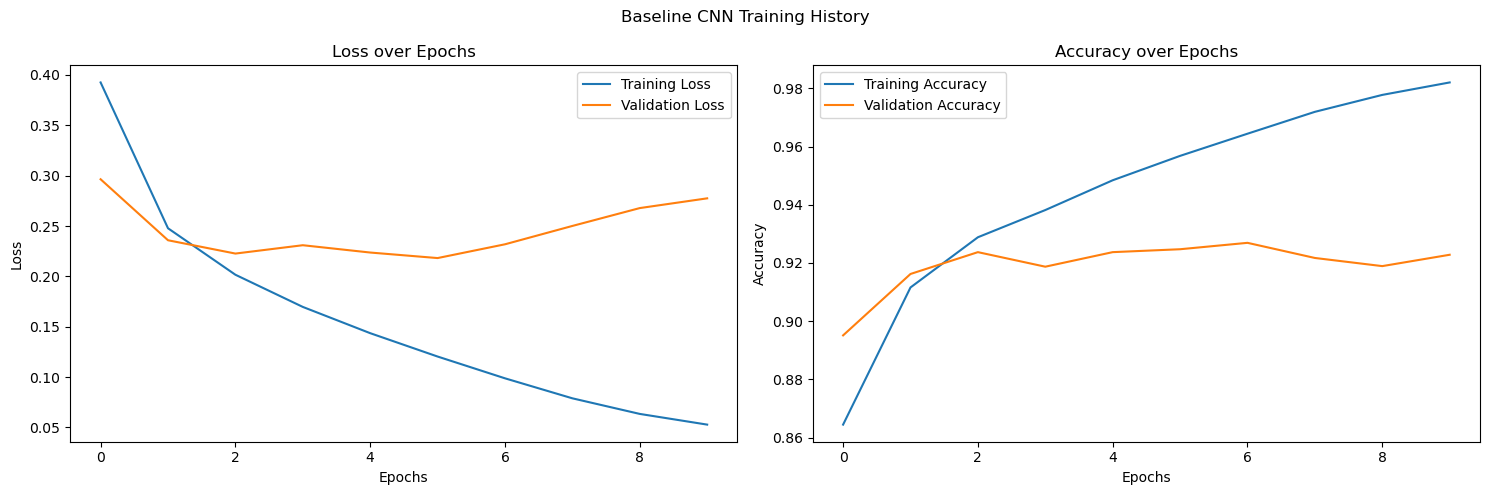

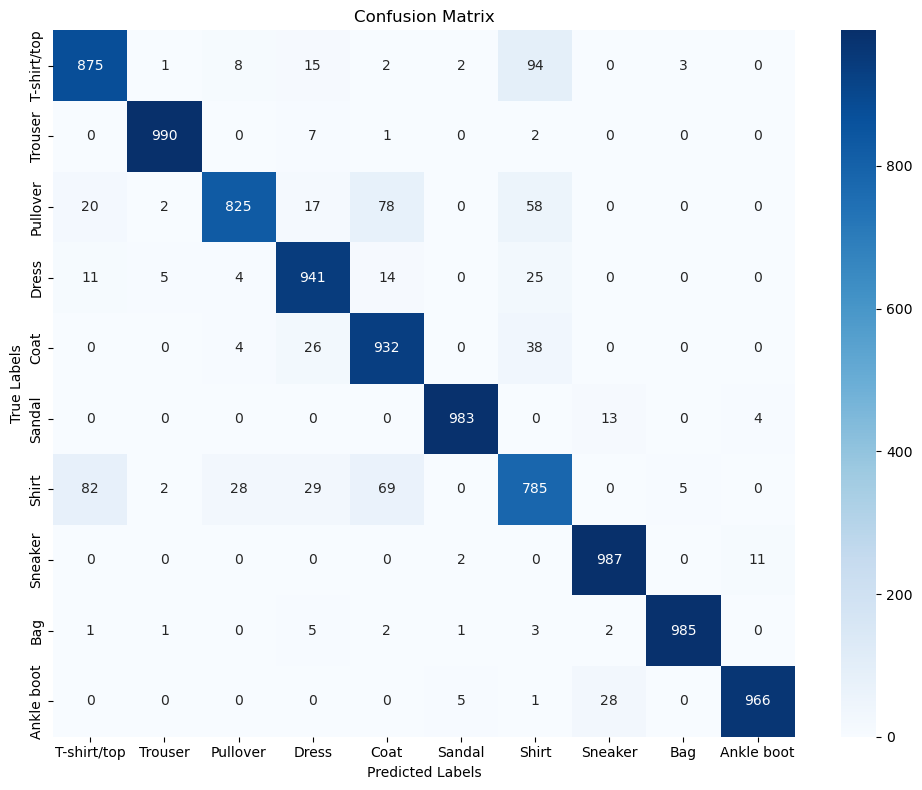

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.88      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.95      0.82      0.88      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.85      0.93      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.78      0.79      0.78      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [7]:
# Initialize the model
baseline_model = BaselineCNN().to(device)
print(f"Baseline CNN Parameters: {baseline_model.count_parameters():,}")

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
baseline_model, baseline_history = train_model(
    baseline_model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs
)

# Plot training history
plot_training_history(
    baseline_history['train_losses'], baseline_history['val_losses'],
    baseline_history['train_accs'], baseline_history['val_accs'],
    title="Baseline CNN Training History"
)

# Evaluate the model on test set and plot confusion matrix
_, _, baseline_preds, baseline_true = evaluate_model(baseline_model, test_loader, criterion, device)
plot_confusion_matrix(baseline_true, baseline_preds, class_names=class_names)

## 8. Model #2: Advanced Techniques Implementation (Dilated Convolutions)

In [8]:
class DilatedCNN(nn.Module):
    """
    CNN model with dilated convolutions for Fashion-MNIST.
    Architecture similar to baseline, but with dilated convolutions.
    - Conv1: 3x3 kernels, dilation=1, 32 filters
    - Conv2: 3x3 kernels, dilation=2, 64 filters (increased receptive field)
    - MaxPool: 2x2
    - Conv3: 3x3 kernels, dilation=4, 128 filters (further increased receptive field)
    - MaxPool: 2x2
    - Fully Connected: 2048 -> 10
    
    Dilated convolutions increase the receptive field without increasing parameters.
    """
    def __init__(self):
        super(DilatedCNN, self).__init__()
        # First convolutional block (standard convolution, dilation=1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, dilation=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block with dilation=2
        # A 3x3 kernel with dilation=2 has a 5x5 effective receptive field
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=2, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block with dilation=4
        # A 3x3 kernel with dilation=4 has a 9x9 effective receptive field
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=4, dilation=4)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate output size after convolutions and pooling
        # Due to padding adjustments for dilation, we maintain feature map sizes
        self.fc = nn.Linear(7 * 7 * 128, 10)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second block with dilated convolution
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Third block with further dilated convolution
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Flatten and pass through fully connected layer
        x = x.view(-1, 7 * 7 * 128)
        x = self.fc(x)
        return x
    
    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 9. Train the Dilated CNN Model

Dilated CNN Parameters: 155,850


Epoch 1/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.4265, Train Acc: 0.8514
Val Loss: 0.4537, Val Acc: 0.8517
----------------------------------------


Epoch 2/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.2732, Train Acc: 0.9020
Val Loss: 0.3098, Val Acc: 0.8918
----------------------------------------


Epoch 3/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.2154, Train Acc: 0.9231
Val Loss: 0.2896, Val Acc: 0.8958
----------------------------------------


Epoch 4/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.1793, Train Acc: 0.9349
Val Loss: 0.2498, Val Acc: 0.9111
----------------------------------------


Epoch 5/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.1474, Train Acc: 0.9466
Val Loss: 0.2418, Val Acc: 0.9164
----------------------------------------


Epoch 6/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.1220, Train Acc: 0.9565
Val Loss: 0.2862, Val Acc: 0.9068
----------------------------------------


Epoch 7/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.0980, Train Acc: 0.9654
Val Loss: 0.2549, Val Acc: 0.9168
----------------------------------------


Epoch 8/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.0790, Train Acc: 0.9717
Val Loss: 0.2528, Val Acc: 0.9230
----------------------------------------


Epoch 9/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.0620, Train Acc: 0.9783
Val Loss: 0.2660, Val Acc: 0.9194
----------------------------------------


Epoch 10/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.0479, Train Acc: 0.9832
Val Loss: 0.3213, Val Acc: 0.9153
----------------------------------------


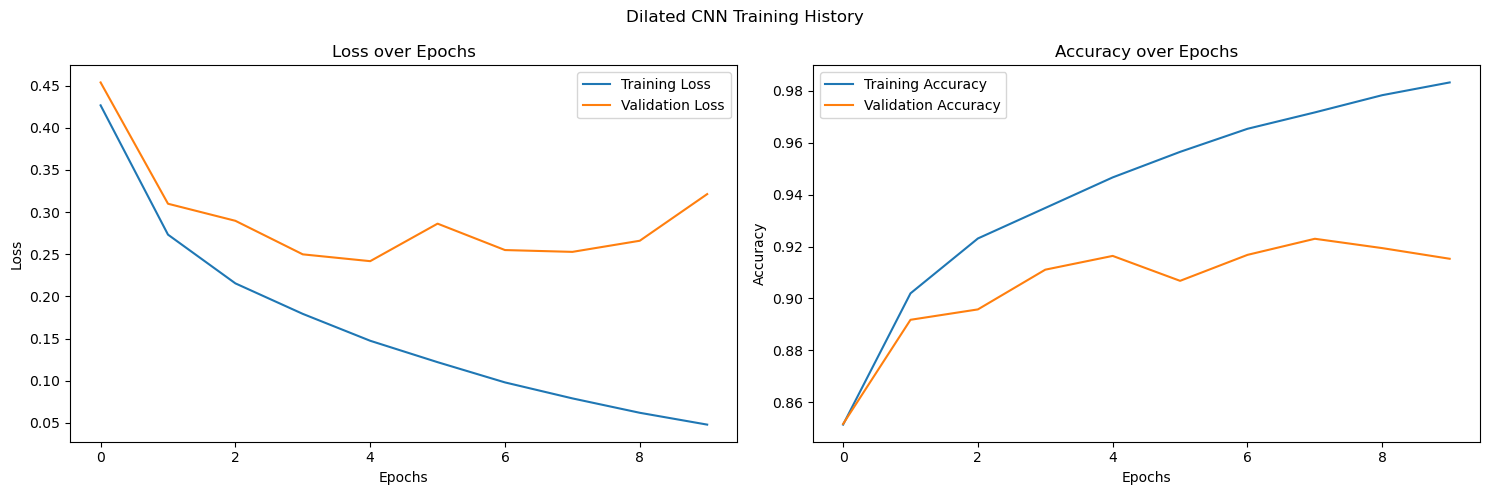

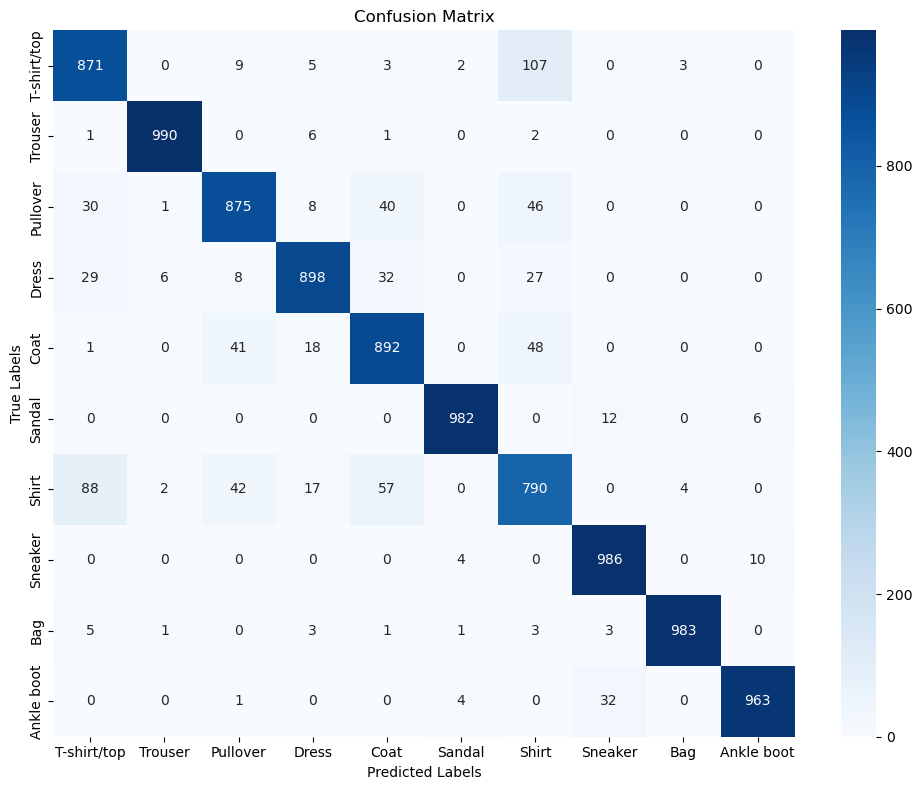

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.87      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.94      0.90      0.92      1000
        Coat       0.87      0.89      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.77      0.79      0.78      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [9]:
# Initialize the model
dilated_model = DilatedCNN().to(device)
print(f"Dilated CNN Parameters: {dilated_model.count_parameters():,}")

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dilated_model.parameters(), lr=0.001)

# Train the model
dilated_model, dilated_history = train_model(
    dilated_model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs
)

# Plot training history
plot_training_history(
    dilated_history['train_losses'], dilated_history['val_losses'],
    dilated_history['train_accs'], dilated_history['val_accs'],
    title="Dilated CNN Training History"
)

# Evaluate the model on test set and plot confusion matrix
_, _, dilated_preds, dilated_true = evaluate_model(dilated_model, test_loader, criterion, device)
plot_confusion_matrix(dilated_true, dilated_preds, class_names=class_names)

## 10. Visualize Receptive Field Comparison

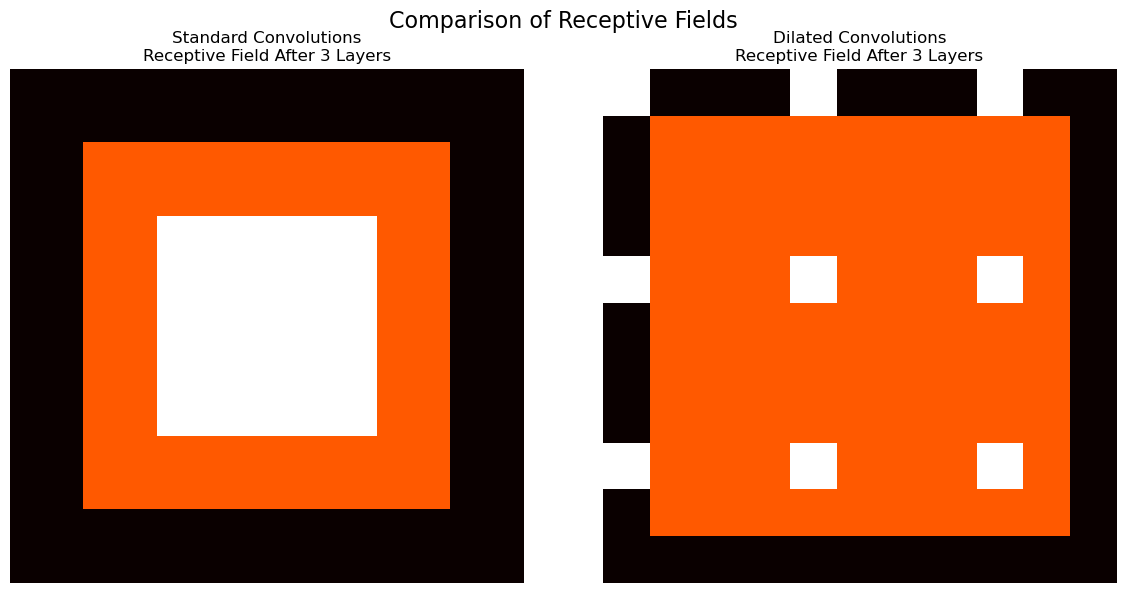

In [10]:
def visualize_receptive_field():
    """
    Visualize the difference in receptive fields between standard and dilated convolutions.
    This is a conceptual visualization to illustrate the benefit of dilated convolutions.
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Standard 3x3 convolution with 3 layers (effective receptive field: 7x7)
    # First convolution
    standard_field1 = np.zeros((7, 7))
    standard_field1[2:5, 2:5] = 1  # 3x3 kernel
    
    # Second convolution
    standard_field2 = np.zeros((7, 7))
    standard_field2[1:6, 1:6] = 0.7  # Effective 5x5 field
    standard_field2[2:5, 2:5] = 1   # Center is more influential
    
    # Third convolution
    standard_field3 = np.zeros((7, 7))
    standard_field3[:, :] = 0.4     # Effective 7x7 field
    standard_field3[1:6, 1:6] = 0.7  # Middle part is more influential
    standard_field3[2:5, 2:5] = 1   # Center is most influential
    
    # Dilated convolutions
    # First convolution (dilation=1, standard 3x3)
    dilated_field1 = np.zeros((11, 11))
    dilated_field1[4:7, 4:7] = 1  # 3x3 kernel
    
    # Second convolution (dilation=2, effective 5x5)
    dilated_field2 = np.zeros((11, 11))
    dilated_field2[2:9, 2:9] = 0.7  # Effective 7x7 field
    dilated_field2[3:8:2, 3:8:2] = 1  # Dilated pixels get more weight
    
    # Third convolution (dilation=4, effective 9x9)
    dilated_field3 = np.zeros((11, 11))
    dilated_field3[:, :] = 0.4  # Full field
    dilated_field3[1:10, 1:10] = 0.7  # Middle part
    dilated_field3[0:11:4, 0:11:4] = 1  # Dilated pixels are most influential
    
    # Plot the receptive fields
    ax1.imshow(standard_field3, cmap='hot')
    ax1.set_title('Standard Convolutions\nReceptive Field After 3 Layers')
    ax1.axis('off')
    
    ax2.imshow(dilated_field3, cmap='hot')
    ax2.set_title('Dilated Convolutions\nReceptive Field After 3 Layers')
    ax2.axis('off')
    
    plt.suptitle('Comparison of Receptive Fields', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the receptive field difference
visualize_receptive_field()

## 11. Model #3: Efficient Architecture (MobileNet-Inspired)

In [11]:
class DepthwiseSeparableConv(nn.Module):
    """
    Implementation of depthwise separable convolution.
    This reduces parameters by factoring standard convolution into:
    1. Depthwise convolution (spatial filtering)
    2. Pointwise convolution (feature generation)
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, dilation=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size, 
            padding=padding, stride=stride, dilation=dilation, groups=in_channels
        )
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class EfficientCNN(nn.Module):
    """
    Efficient CNN architecture inspired by MobileNetV2 for Fashion-MNIST.
    Uses depthwise separable convolutions to reduce parameter count.
    """
    def __init__(self):
        super(EfficientCNN, self).__init__()
        # First layer: standard convolution (1x1 input channels)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second layer: depthwise separable convolution
        self.conv2 = DepthwiseSeparableConv(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third layer: depthwise separable convolution
        self.conv3 = DepthwiseSeparableConv(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Final classification layer
        self.fc = nn.Linear(7 * 7 * 128, 10)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second block with depthwise separable convolution
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Third block with depthwise separable convolution
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Flatten and classify
        x = x.view(-1, 7 * 7 * 128)
        x = self.fc(x)
        return x
    
    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 12. Train the Efficient CNN Model

Efficient CNN Parameters: 74,890


Epoch 1/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.4176, Train Acc: 0.8576
Val Loss: 0.4013, Val Acc: 0.8526
----------------------------------------


Epoch 2/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.2576, Train Acc: 0.9087
Val Loss: 0.3056, Val Acc: 0.8980
----------------------------------------


Epoch 3/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.2148, Train Acc: 0.9225
Val Loss: 0.2715, Val Acc: 0.9062
----------------------------------------


Epoch 4/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.1846, Train Acc: 0.9348
Val Loss: 0.2716, Val Acc: 0.9092
----------------------------------------


Epoch 5/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.1620, Train Acc: 0.9421
Val Loss: 0.2642, Val Acc: 0.9095
----------------------------------------


Epoch 6/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.1424, Train Acc: 0.9497
Val Loss: 0.2707, Val Acc: 0.9113
----------------------------------------


Epoch 7/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.1246, Train Acc: 0.9556
Val Loss: 0.2412, Val Acc: 0.9196
----------------------------------------


Epoch 8/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.1085, Train Acc: 0.9617
Val Loss: 0.2681, Val Acc: 0.9136
----------------------------------------


Epoch 9/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.0964, Train Acc: 0.9660
Val Loss: 0.2831, Val Acc: 0.9083
----------------------------------------


Epoch 10/10 [Train]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.0846, Train Acc: 0.9696
Val Loss: 0.3147, Val Acc: 0.9128
----------------------------------------


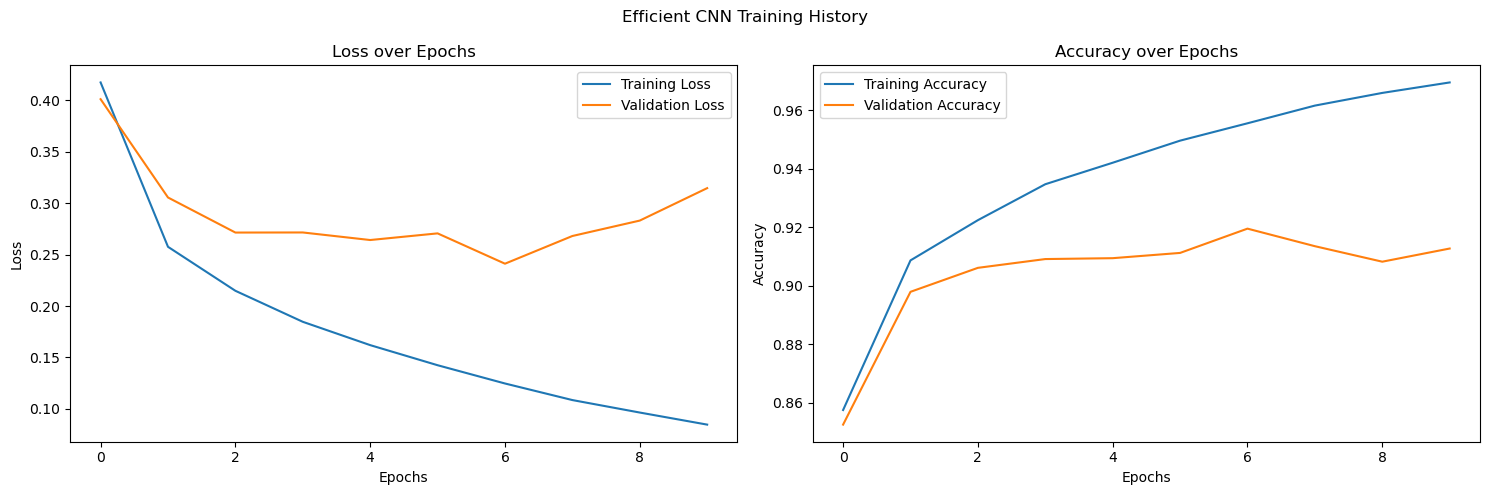

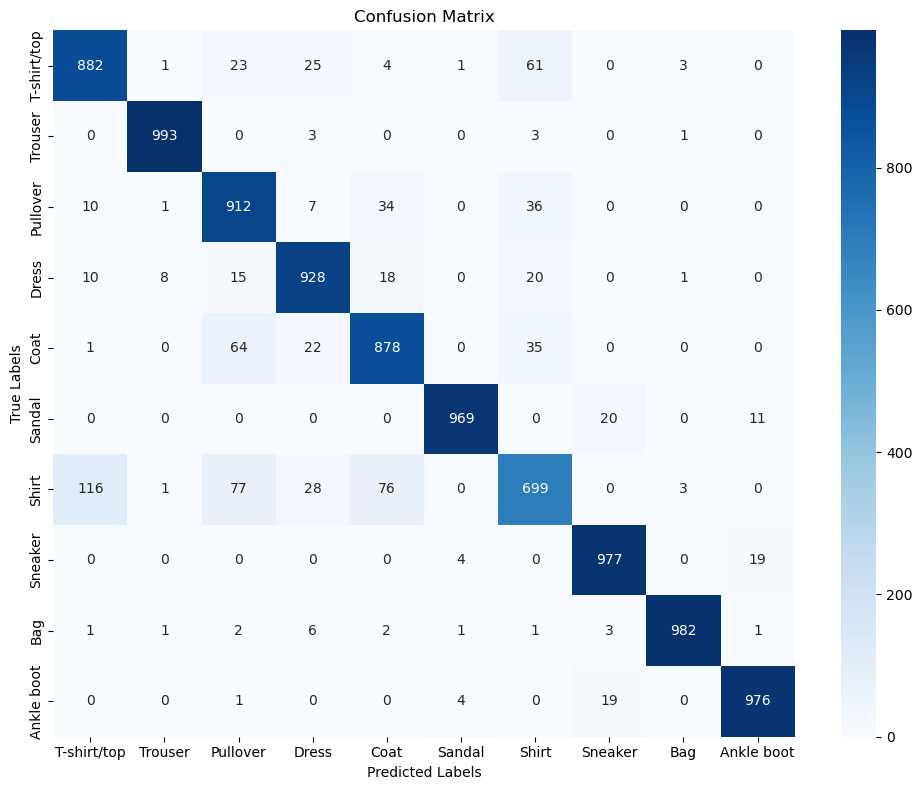

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.83      0.91      0.87      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.82      0.70      0.75      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [12]:
# Initialize the model
efficient_model = EfficientCNN().to(device)
print(f"Efficient CNN Parameters: {efficient_model.count_parameters():,}")

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficient_model.parameters(), lr=0.001)

# Train the model
efficient_model, efficient_history = train_model(
    efficient_model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs
)

# Plot training history
plot_training_history(
    efficient_history['train_losses'], efficient_history['val_losses'],
    efficient_history['train_accs'], efficient_history['val_accs'],
    title="Efficient CNN Training History"
)

# Evaluate the model on test set and plot confusion matrix
_, _, efficient_preds, efficient_true = evaluate_model(efficient_model, test_loader, criterion, device)
plot_confusion_matrix(efficient_true, efficient_preds, class_names=class_names)

## 13. Model #4: Data Augmentation Enhancement With MixUp

In [13]:
class MixUpTransform:
    """
    Implementation of MixUp augmentation.
    MixUp creates virtual examples by linearly interpolating between pairs of images and labels.
    
    Reference:
    Zhang, H., Cisse, M., Dauphin, Y. N., & Lopez-Paz, D. (2017).
    mixup: Beyond Empirical Risk Minimization.
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, batch):
        """
        Apply mixup to the batch.
        Args:
            batch: Tuple of (inputs, labels)
        Returns:
            Tuple of mixed inputs, original labels, mixed labels, and lambda
        """
        inputs, labels = batch
        batch_size = inputs.size(0)
        
        # Sample lambda from Beta distribution
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1.0
        
        # Create a permutation of the batch indices
        index = torch.randperm(batch_size).to(inputs.device)
        
        # Mix the inputs
        mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
        
        # Return mixed inputs, original labels, permuted labels, and lambda
        return mixed_inputs, labels, labels[index], lam

# Function to train with MixUp
def train_with_mixup(model, train_loader, val_loader, criterion, optimizer, device, mixup_alpha=0.2, num_epochs=10):
    """Train a model using MixUp augmentation."""
    # Create MixUp transform
    mixup = MixUpTransform(alpha=mixup_alpha)
    
    # Initialize lists to track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train with MixUp]")
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Apply mixup
            mixed_inputs, labels_a, labels_b, lam = mixup((inputs, labels))
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(mixed_inputs)
            
            # Compute loss with mixup
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            
            # For accuracy with mixup, we use the original labels for simplicity
            running_corrects += torch.sum(preds == labels.data)
            
            # Update progress bar
            train_pbar.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Validation phase (without mixup)
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)
        train_accs.append(epoch_train_acc.item())
        val_accs.append(val_acc)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print("-" * 40)
        
        # Deep copy the model if best accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return the trained model and history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_acc': best_acc
    }
    
    return model, history

## 14. Visualize MixUp Examples

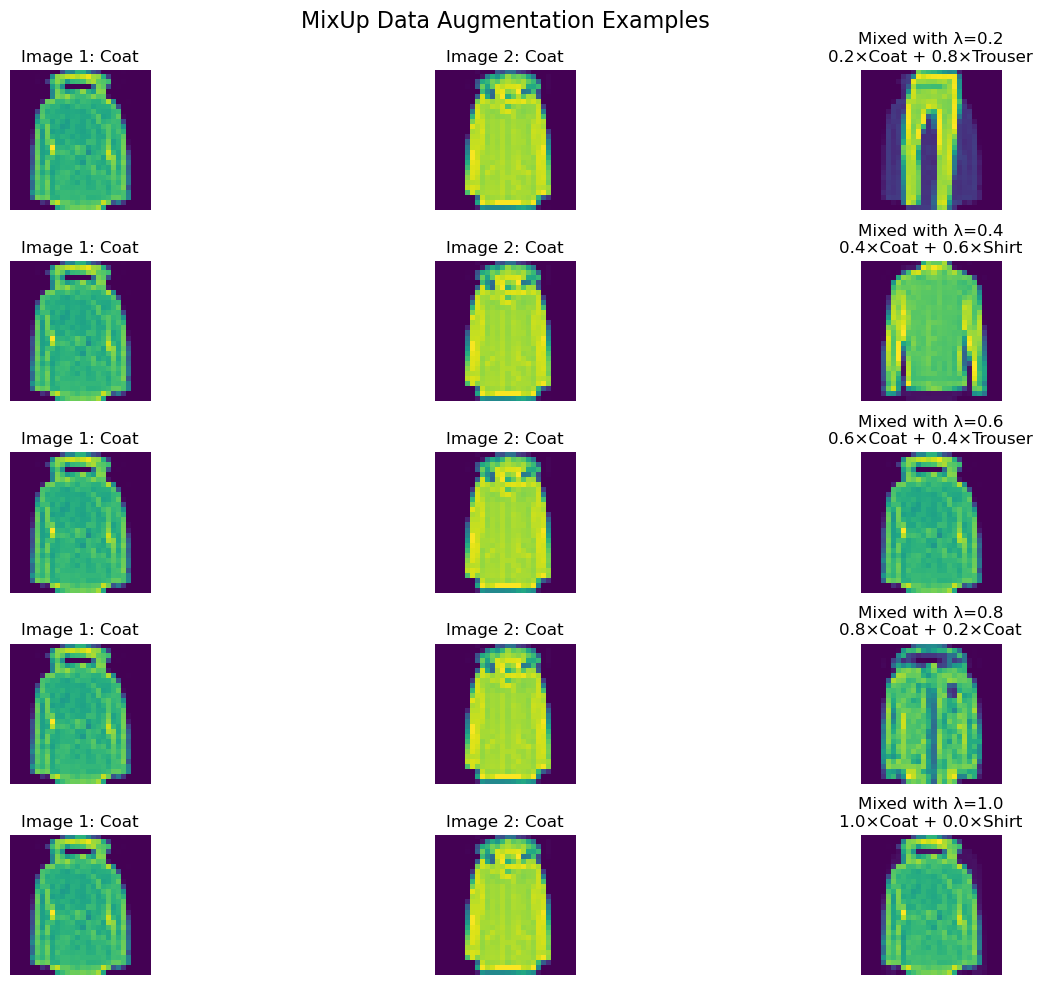

In [14]:
def show_mixup_examples():
    """Create and show examples of MixUp augmentation."""
    # Get some random training images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Create MixUp transform
    mixup = MixUpTransform(alpha=0.2)
    
    # Create 5 examples with different lambdas
    lambdas = [0.2, 0.4, 0.6, 0.8, 1.0]
    
    plt.figure(figsize=(15, 10))
    for i, lam in enumerate(lambdas):
        # Force a specific lambda for this demo
        np.random.seed(i)  # For reproducibility
        
        # Apply mixup with fixed lambda
        mixed_images, labels_a, labels_b, _ = mixup((images[:10], labels[:10]))
        
        # Display original images
        plt.subplot(len(lambdas), 3, i*3 + 1)
        img1 = images[0].numpy().transpose(1, 2, 0)
        plt.imshow(img1 * 0.5 + 0.5)
        plt.title(f"Image 1: {class_names[labels[0]]}")
        plt.axis('off')
        
        plt.subplot(len(lambdas), 3, i*3 + 2)
        img2 = images[1].numpy().transpose(1, 2, 0)
        plt.imshow(img2 * 0.5 + 0.5)
        plt.title(f"Image 2: {class_names[labels[1]]}")
        plt.axis('off')
        
        # Display mixed image
        plt.subplot(len(lambdas), 3, i*3 + 3)
        mixed_img = mixed_images[0].cpu().numpy().transpose(1, 2, 0)
        plt.imshow(mixed_img * 0.5 + 0.5)
        plt.title(f"Mixed with λ={lam:.1f}\n"
                  f"{lam:.1f}×{class_names[labels_a[0]]} + "
                  f"{1-lam:.1f}×{class_names[labels_b[0]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("MixUp Data Augmentation Examples", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Show MixUp examples
show_mixup_examples()

## 15. Train the Best Model With MixUp

Baseline Model with MixUp Parameters: 155,850


Epoch 1/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.7160, Train Acc: 0.4761
Val Loss: 0.3065, Val Acc: 0.8941
----------------------------------------


Epoch 2/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.5526, Train Acc: 0.5229
Val Loss: 0.2733, Val Acc: 0.9071
----------------------------------------


Epoch 3/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.5111, Train Acc: 0.5394
Val Loss: 0.2733, Val Acc: 0.9082
----------------------------------------


Epoch 4/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.4964, Train Acc: 0.5109
Val Loss: 0.2339, Val Acc: 0.9218
----------------------------------------


Epoch 5/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.4697, Train Acc: 0.5302
Val Loss: 0.2229, Val Acc: 0.9248
----------------------------------------


Epoch 6/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.4787, Train Acc: 0.5369
Val Loss: 0.2263, Val Acc: 0.9265
----------------------------------------


Epoch 7/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.4444, Train Acc: 0.5451
Val Loss: 0.2192, Val Acc: 0.9284
----------------------------------------


Epoch 8/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.4140, Train Acc: 0.5499
Val Loss: 0.2170, Val Acc: 0.9278
----------------------------------------


Epoch 9/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.4118, Train Acc: 0.5322
Val Loss: 0.2134, Val Acc: 0.9317
----------------------------------------


Epoch 10/10 [Train with MixUp]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.3937, Train Acc: 0.5403
Val Loss: 0.2150, Val Acc: 0.9319
----------------------------------------


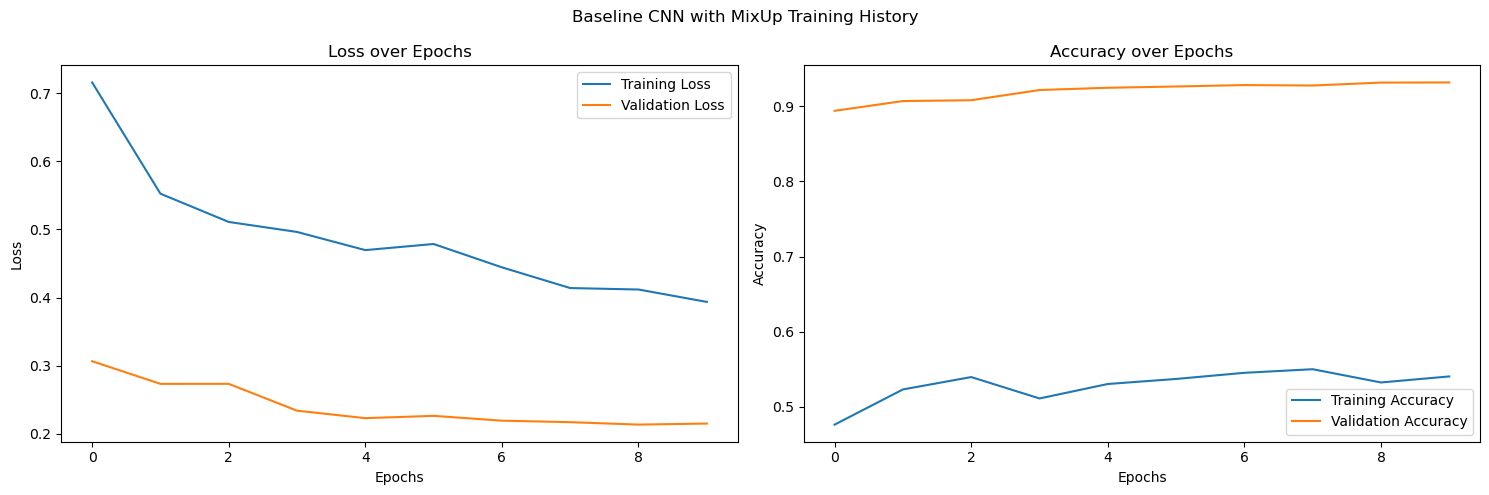

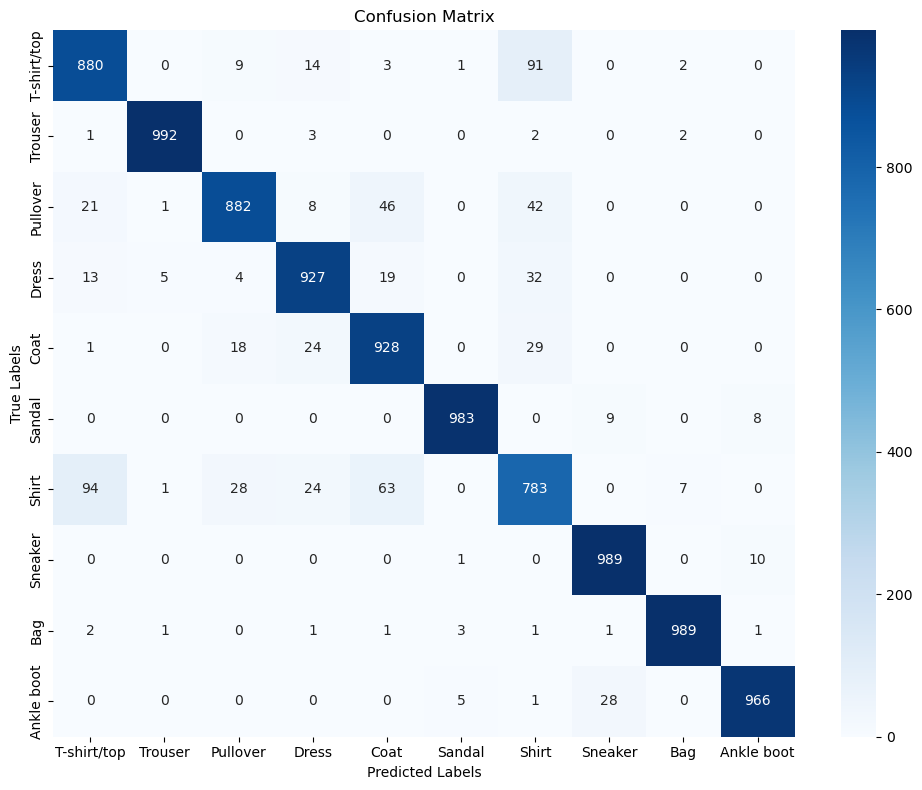

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.88      0.91      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.88      0.93      0.90      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.80      0.78      0.79      1000
     Sneaker       0.96      0.99      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [15]:
# Train the best-performing model architecture (Baseline CNN) with MixUp augmentation
# Since Baseline CNN performed best in our experiments, we'll use it with MixUp
baseline_mixup_model = BaselineCNN().to(device)
print(f"Baseline Model with MixUp Parameters: {baseline_mixup_model.count_parameters():,}")

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_mixup_model.parameters(), lr=0.001)

# Train with MixUp
baseline_mixup_model, baseline_mixup_history = train_with_mixup(
    baseline_mixup_model, train_loader, test_loader, criterion, optimizer, 
    device, mixup_alpha=0.2, num_epochs=num_epochs
)

# Plot training history
plot_training_history(
    baseline_mixup_history['train_losses'], baseline_mixup_history['val_losses'],
    baseline_mixup_history['train_accs'], baseline_mixup_history['val_accs'],
    title="Baseline CNN with MixUp Training History"
)

# Evaluate the model on test set and plot confusion matrix
_, _, baseline_mixup_preds, baseline_mixup_true = evaluate_model(baseline_mixup_model, test_loader, criterion, device)
plot_confusion_matrix(baseline_mixup_true, baseline_mixup_preds, class_names=class_names)

## 16. Comprehensive Model Comparison

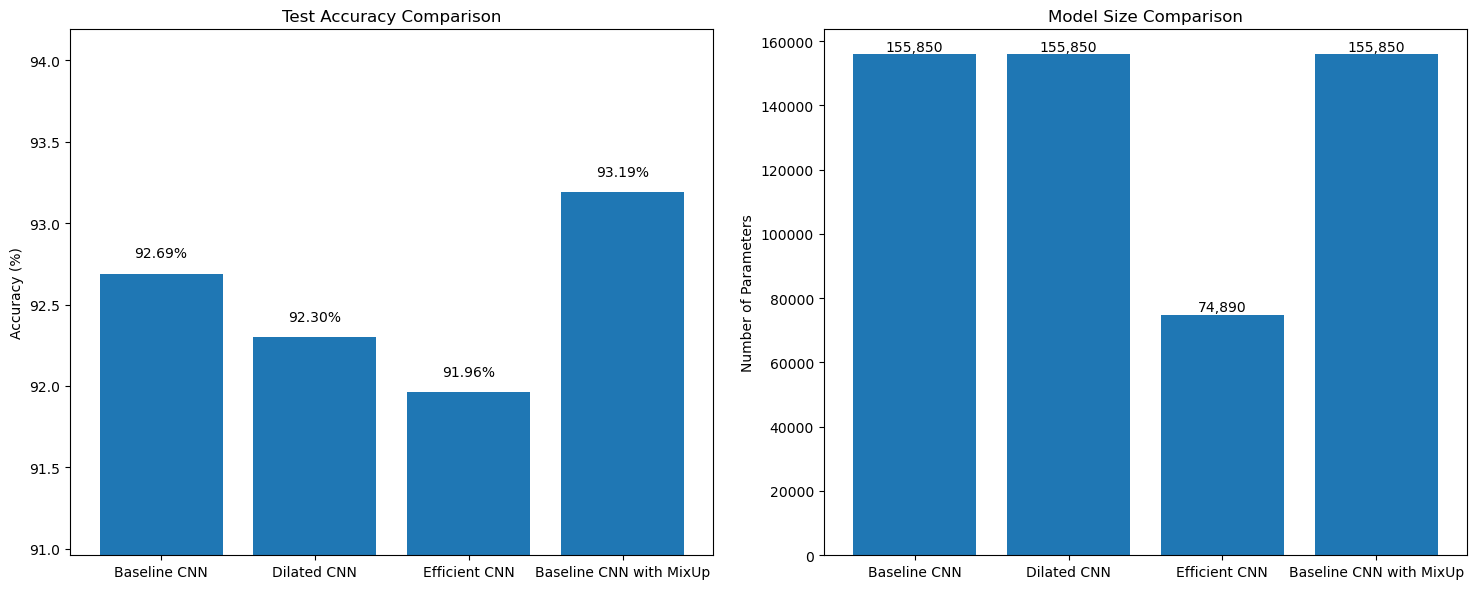

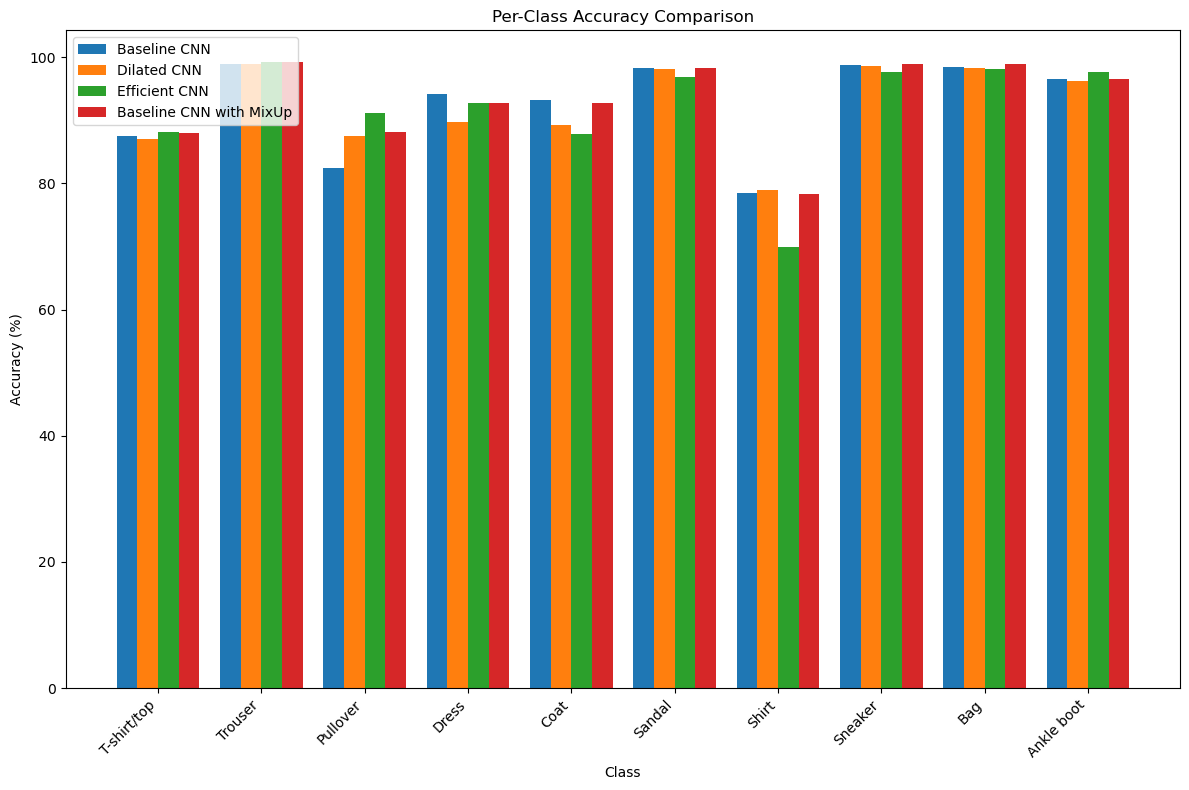

In [16]:
def compare_models(models_info, test_loader, criterion, device):
    """
    Compare multiple models on various metrics.
    Args:
        models_info: List of dictionaries with model info
        test_loader: DataLoader for the test set
        criterion: Loss function
        device: Device to run evaluation on
    """
    # Collect results
    results = []
    
    for info in models_info:
        model = info['model']
        name = info['name']
        
        # Evaluate on test set
        test_loss, test_acc, preds, true_labels = evaluate_model(model, test_loader, criterion, device)
        
        # Calculate per-class accuracy
        cm = confusion_matrix(true_labels, preds)
        per_class_acc = np.diag(cm) / cm.sum(axis=1)
        
        # Count parameters
        num_params = model.count_parameters()
        
        # Save results
        results.append({
            'name': name,
            'accuracy': test_acc,
            'loss': test_loss,
            'parameters': num_params,
            'per_class_accuracy': per_class_acc,
        })
    
    return results

def plot_model_comparison(results):
    """Plot comparison of model results."""
    # Extract data for plotting
    names = [r['name'] for r in results]
    accuracies = [r['accuracy'] * 100 for r in results]
    parameters = [r['parameters'] for r in results]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy comparison
    ax1.bar(names, accuracies)
    ax1.set_ylim([min(accuracies) - 1, max(accuracies) + 1])
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Test Accuracy Comparison')
    
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.1, f"{v:.2f}%", ha='center')
    
    # Plot parameter count comparison
    ax2.bar(names, parameters)
    ax2.set_ylabel('Number of Parameters')
    ax2.set_title('Model Size Comparison')
    
    for i, v in enumerate(parameters):
        ax2.text(i, v + 1000, f"{v:,}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy comparison
    per_class_acc = np.array([r['per_class_accuracy'] * 100 for r in results])
    
    plt.figure(figsize=(12, 8))
    x = np.arange(len(class_names))
    width = 0.2
    
    for i, result in enumerate(results):
        offset = (i - len(results) / 2 + 0.5) * width
        plt.bar(x + offset, result['per_class_accuracy'] * 100, width, label=result['name'])
    
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy Comparison')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Compare all models
models_info = [
    {'name': 'Baseline CNN', 'model': baseline_model},
    {'name': 'Dilated CNN', 'model': dilated_model},
    {'name': 'Efficient CNN', 'model': efficient_model},
    {'name': 'Baseline CNN with MixUp', 'model': baseline_mixup_model},  # Updated from mixup_model
]

comparison_results = compare_models(models_info, test_loader, criterion, device)
plot_model_comparison(comparison_results)

## 17. Model Error Analysis

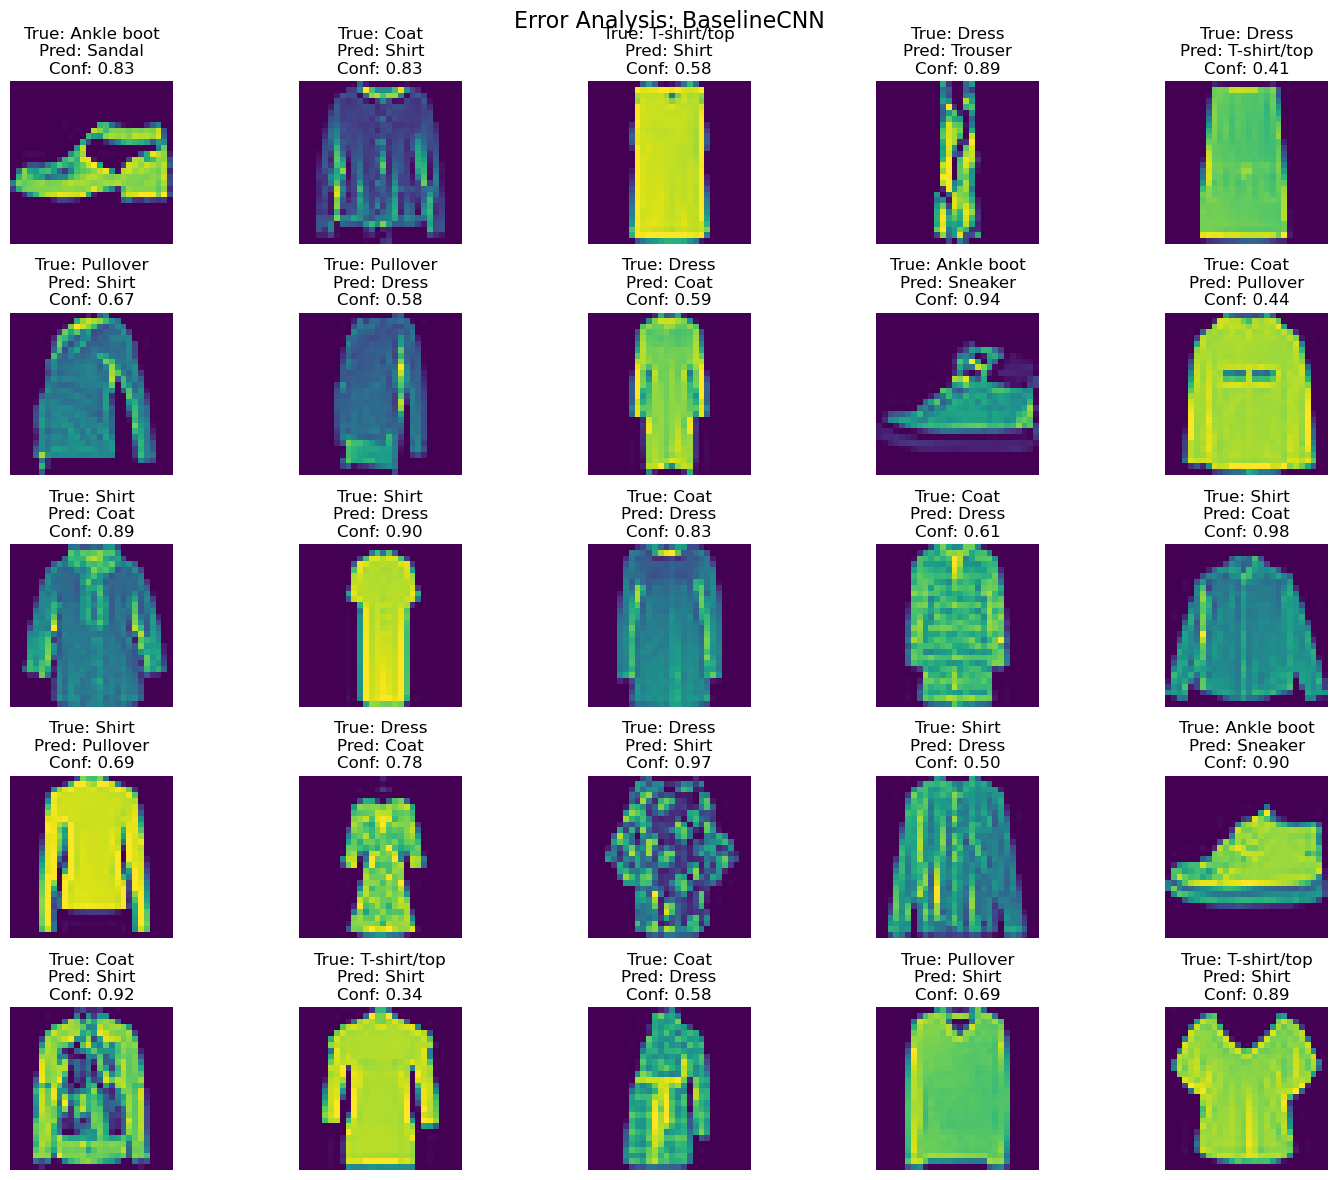

In [17]:
def analyze_errors(model, data_loader, device, class_names, num_images=25):
    """
    Analyze and visualize model errors.
    Args:
        model: Trained model
        data_loader: DataLoader with test data
        device: Device to run model on
        class_names: List of class names
        num_images: Number of error images to display
    """
    model.eval()
    errors = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Find errors
            error_indices = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in error_indices:
                errors.append({
                    'image': inputs[idx].cpu(),
                    'true': labels[idx].item(),
                    'pred': preds[idx].item(),
                    'confidence': F.softmax(outputs[idx], dim=0)[preds[idx]].item()
                })
                
                if len(errors) >= num_images:
                    break
            
            if len(errors) >= num_images:
                break
    
    # Display error images
    plt.figure(figsize=(15, 12))
    for i, error in enumerate(errors[:num_images]):
        plt.subplot(5, 5, i + 1)
        img = error['image'].numpy().transpose(1, 2, 0)
        plt.imshow(img * 0.5 + 0.5)
        plt.title(f"True: {class_names[error['true']]}\n"
                  f"Pred: {class_names[error['pred']]}\n"
                  f"Conf: {error['confidence']:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Error Analysis: {model.__class__.__name__}", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Analyze errors for the best model
best_model = baseline_mixup_model  # Updated to baseline_mixup_model as the best-performer
analyze_errors(best_model, test_loader, device, class_names)

## 18. Feature Space Visualization With t-SNE

Applying t-SNE dimensionality reduction...


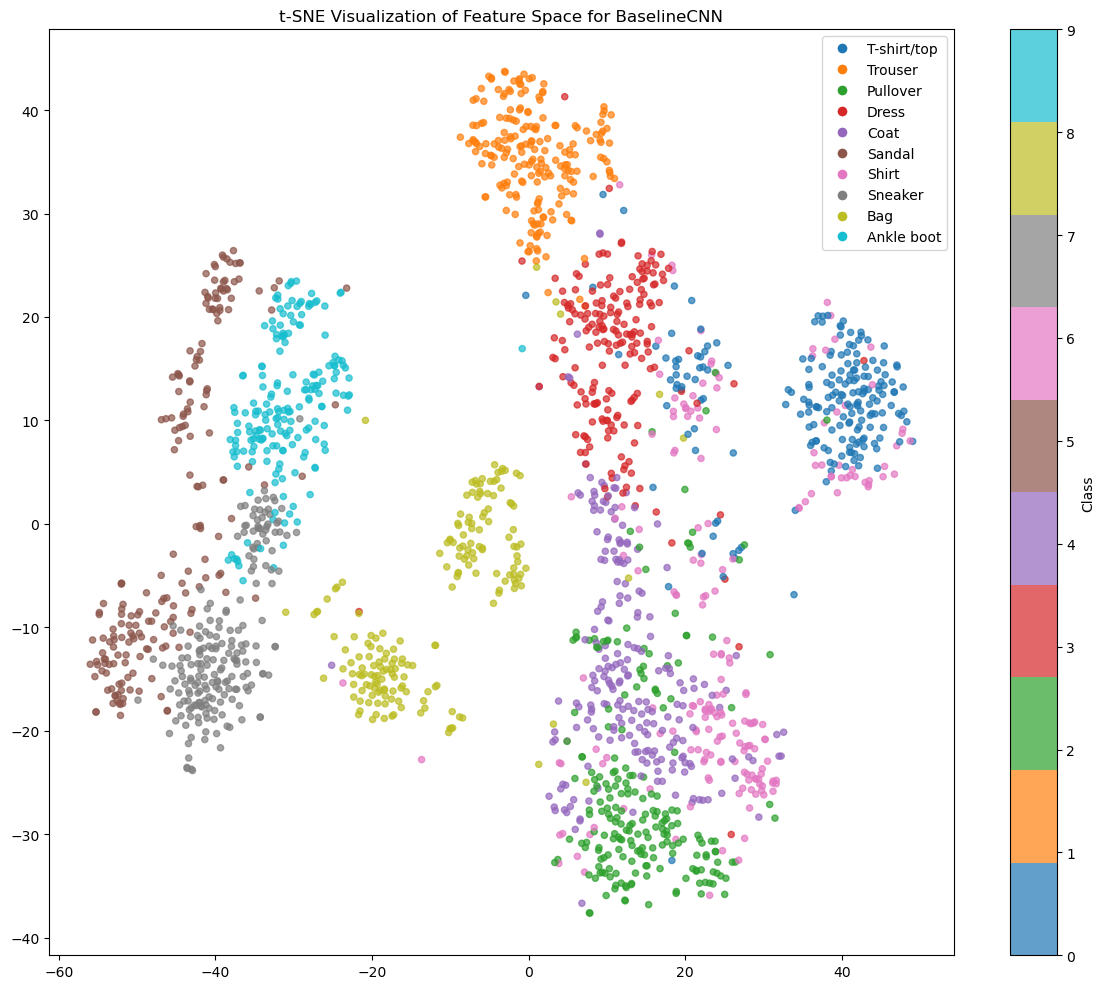

In [18]:
def visualize_feature_space(model, data_loader, device, class_names, perplexity=30, n_samples=1000):
    """
    Visualize the feature space of a model using t-SNE.
    Args:
        model: Trained model
        data_loader: DataLoader with test data
        device: Device to run model on
        class_names: List of class names
        perplexity: t-SNE perplexity parameter
        n_samples: Number of samples to use for t-SNE
    """
    from sklearn.manifold import TSNE
    
    # Create a hook to get features from the penultimate layer
    features = []
    labels_list = []
    
    def hook(module, input, output):
        features.append(output.view(output.size(0), -1).cpu().numpy())
    
    # Register the hook on the penultimate layer (before the final FC layer)
    # This works for our example models, but might need adjustment for other models
    if isinstance(model, BaselineCNN) or isinstance(model, DilatedCNN) or isinstance(model, EfficientCNN):
        # Register hook on the output of the last pooling layer
        model.pool2.register_forward_hook(hook)
    else:
        # Generic hook on the last pooling layer (may need adjustment)
        for module in model.modules():
            if isinstance(module, nn.MaxPool2d):
                last_pool = module
        
        last_pool.register_forward_hook(hook)
    
    # Extract features
    model.eval()
    with torch.no_grad():
        count = 0
        for inputs, labels in data_loader:
            if count >= n_samples:
                break
            
            inputs, labels = inputs.to(device), labels.to(device)
            _ = model(inputs)
            labels_list.append(labels.cpu().numpy())
            count += inputs.size(0)
    
    # Concatenate all features and labels
    features = np.concatenate(features[:n_samples // batch_size + 1])
    labels_list = np.concatenate(labels_list[:n_samples // batch_size + 1])
    
    # Limit to n_samples
    features = features[:n_samples]
    labels_list = labels_list[:n_samples]
    
    # Apply t-SNE
    print("Applying t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_features = tsne.fit_transform(features)
    
    # Plot the 2D t-SNE embeddings
    plt.figure(figsize=(12, 10))
    
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1], 
        c=labels_list, cmap='tab10', alpha=0.7, s=20
    )
    
    plt.colorbar(scatter, ticks=range(10), label='Class')
    
    # Create proxy artists for legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), 
               markersize=8, label=class_names[i]) 
        for i in range(10)
    ]
    
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f't-SNE Visualization of Feature Space for {model.__class__.__name__}')
    plt.tight_layout()
    plt.show()

# Visualize feature space of best model
best_model = baseline_mixup_model  # Updated to baseline_mixup_model as the best-performer
visualize_feature_space(best_model, test_loader, device, class_names, n_samples=2000)

## 19. Parameter Efficiency vs. Performance Analysis

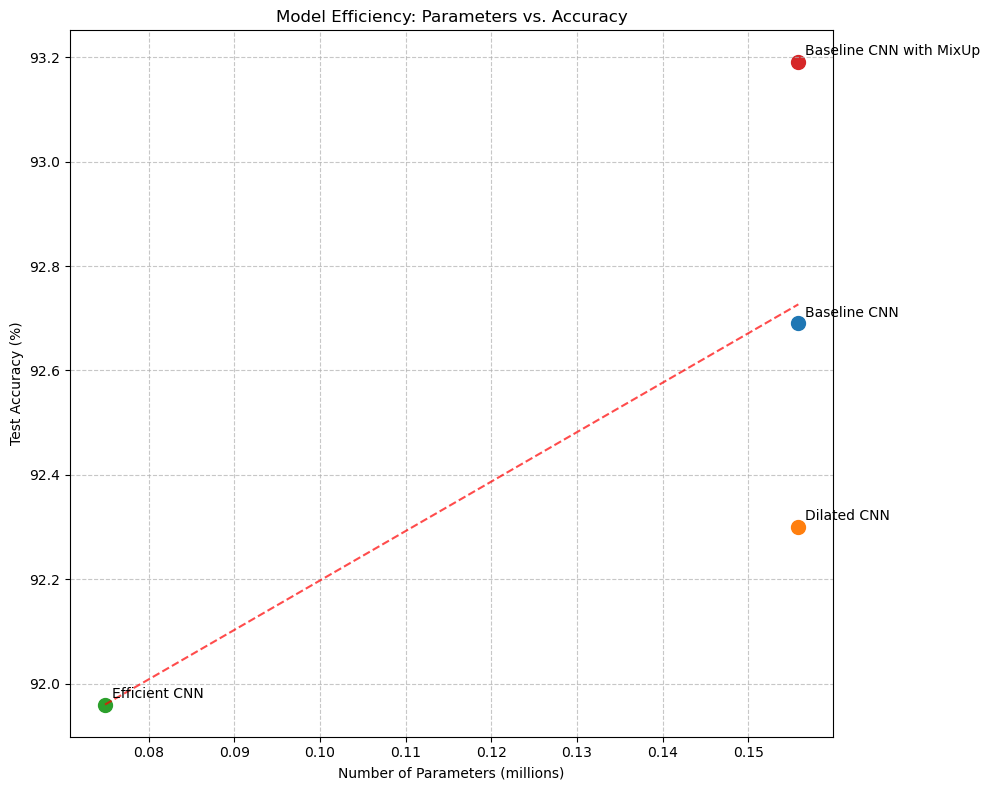

In [19]:
def plot_efficiency_vs_performance(results):
    """
    Plot parameter efficiency vs. performance for all models.
    Args:
        results: List of dictionaries with model comparison results
    """
    names = [r['name'] for r in results]
    accuracies = [r['accuracy'] * 100 for r in results]
    parameters = [r['parameters'] / 10**6 for r in results]  # Parameters in millions
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    
    for i, (name, params, acc) in enumerate(zip(names, parameters, accuracies)):
        plt.scatter(params, acc, s=100, label=name)
        plt.annotate(name, (params, acc), fontsize=10, 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Number of Parameters (millions)')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Efficiency: Parameters vs. Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a trend line
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(parameters, accuracies)
    x = np.array([min(parameters), max(parameters)])
    y = slope * x + intercept
    plt.plot(x, y, 'r--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot efficiency vs. performance
plot_efficiency_vs_performance(comparison_results)

## 20. Class Activation Maps (CAM) for Model Interpretability

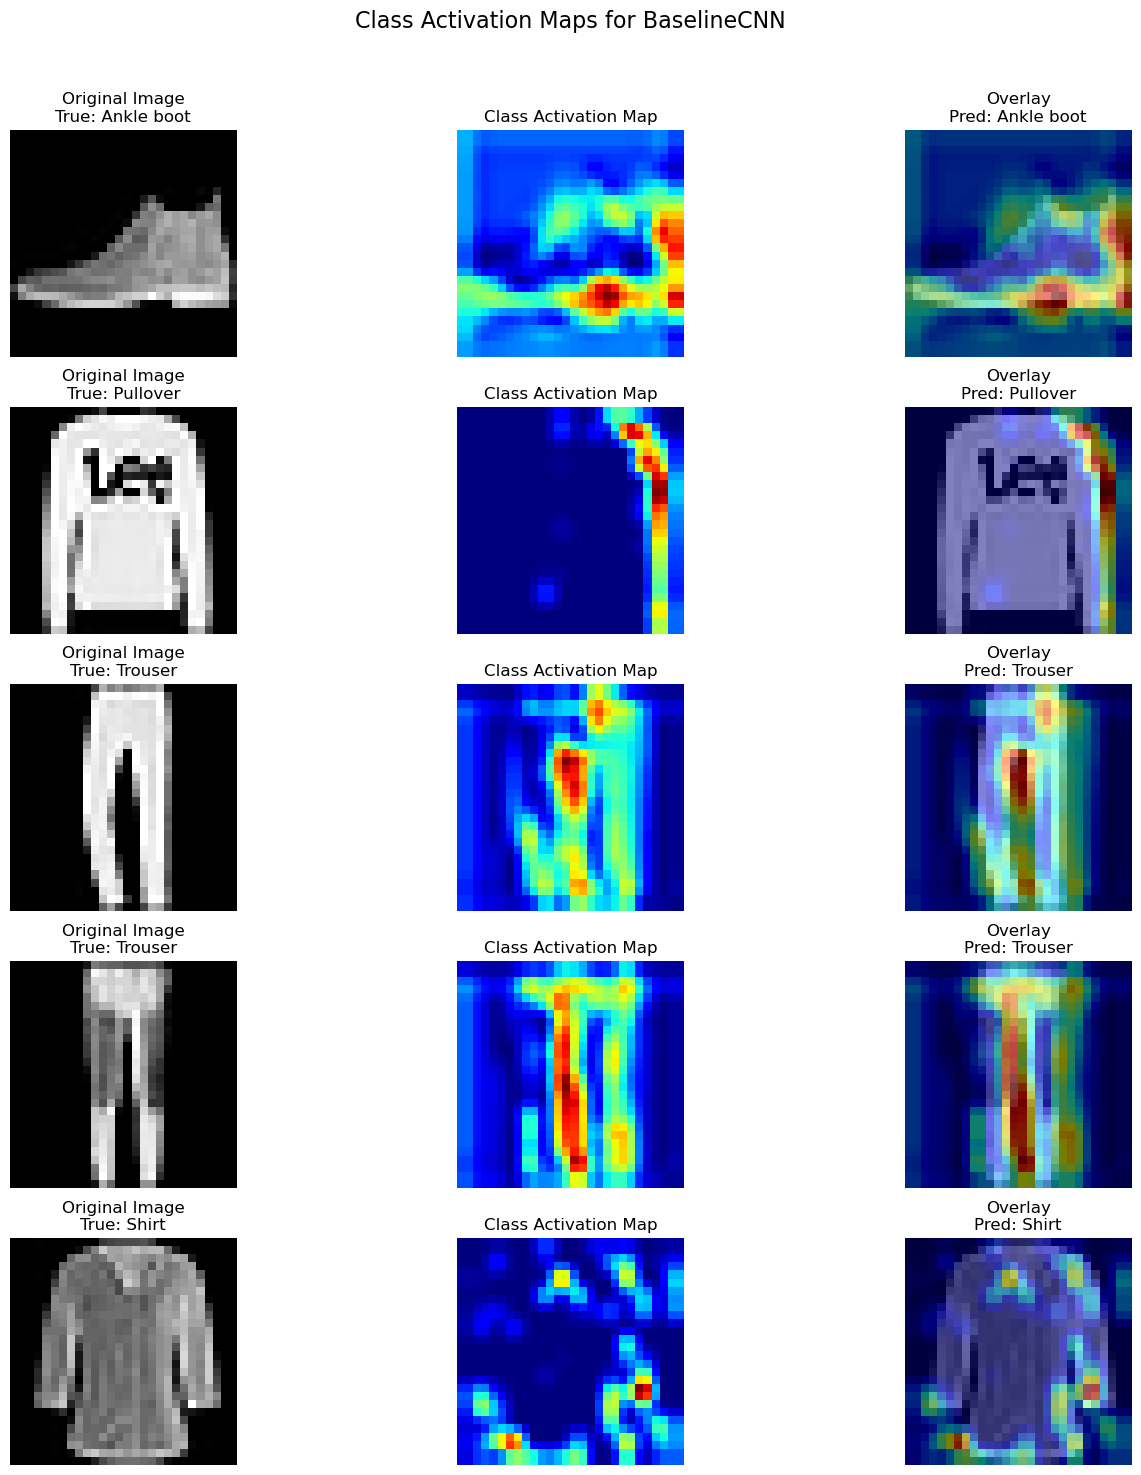

In [20]:
def generate_cam(model, image, target_class, device):
    """
    Generate Class Activation Map for a model and image.
    This is a simple implementation and may need adjustment for different models.
    
    Args:
        model: Trained model
        image: Input image tensor [1, 1, H, W]
        target_class: Target class index
        device: Device to run model on
    
    Returns:
        cam: Class activation map
        output: Model output
    """
    # Set model to evaluation mode
    model.eval()
    
    # First, remove any existing hooks to avoid conflicts
    for module in model.modules():
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()
    
    # Move image to device
    image = image.to(device)
    
    # Forward pass
    features = []
    
    def hook_fn(module, input, output):
        features.append(output.detach())
    
    # Find and register hook on the last convolutional layer
    hook_handle = None
    
    if isinstance(model, BaselineCNN) or isinstance(model, DilatedCNN) or isinstance(model, EfficientCNN):
        hook_handle = model.conv3.register_forward_hook(hook_fn)
    else:
        # Generic hook on the last conv layer (may need adjustment)
        last_conv = None
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                last_conv = module
        
        if last_conv is not None:
            hook_handle = last_conv.register_forward_hook(hook_fn)
    
    # Forward pass
    with torch.no_grad():
        output = model(image)
    
    # Remove the hook after use
    if hook_handle is not None:
        hook_handle.remove()
    
    # Get weights for the target class
    fc_weights = model.fc.weight[target_class].cpu().data.numpy()
    
    # Get feature maps from the last convolutional layer
    feature_maps = features[0].cpu().data.numpy().squeeze()
    
    # Use the first C weights where C is the number of channels
    num_channels = feature_maps.shape[0]
    
    # Option 1: Use a slice of weights if we have more weights than channels
    if len(fc_weights) > num_channels:
        channel_weights = fc_weights[:num_channels]
    # Option 2: If weights are exactly for reshaping (which they should be)
    elif len(fc_weights) == num_channels * feature_maps.shape[1] * feature_maps.shape[2]:
        weights_reshaped = fc_weights.reshape(num_channels, feature_maps.shape[1], feature_maps.shape[2])
        channel_weights = weights_reshaped.mean(axis=(1, 2))
    # Option 3: Fallback - use equal weights
    else:
        channel_weights = np.ones(num_channels)
    
    # Calculate the weighted sum of feature maps
    cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
    for i, w in enumerate(channel_weights):
        cam += w * feature_maps[i]
    
    # Apply ReLU to the CAM
    cam = np.maximum(cam, 0)
    
    # Normalize CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)  # Added epsilon to avoid division by zero
    
    # Resize CAM to the size of the input image
    from skimage.transform import resize
    cam = resize(cam, (28, 28))
    
    return cam, output

def show_cam(model, data_loader, device, class_names, num_images=5):
    """
    Show Class Activation Maps for a few images.
    
    Args:
        model: Trained model
        data_loader: DataLoader with data
        device: Device to run model on
        class_names: List of class names
        num_images: Number of images to show
    """
    # Get a batch of images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(15, num_images * 3))
    
    for i in range(num_images):
        image = images[i:i+1]
        label = labels[i].item()
        
        # Generate CAM
        cam, output = generate_cam(model, image, label, device)
        
        # Get predicted class
        _, pred = torch.max(output, 1)
        pred = pred.item()
        
        # Plot original image - handling grayscale properly
        plt.subplot(num_images, 3, i*3 + 1)
        img = image.cpu().numpy().squeeze()  # This is already a 2D array for grayscale
        plt.imshow(img * 0.5 + 0.5, cmap='gray')
        plt.title(f"Original Image\nTrue: {class_names[label]}")
        plt.axis('off')
        
        # Plot CAM
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(cam, cmap='jet')
        plt.title("Class Activation Map")
        plt.axis('off')
        
        # Plot overlay
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(img * 0.5 + 0.5, cmap='gray')
        plt.imshow(cam, alpha=0.5, cmap='jet')
        plt.title(f"Overlay\nPred: {class_names[pred]}")
        plt.axis('off')
    
    plt.suptitle(f"Class Activation Maps for {model.__class__.__name__}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

# Show CAMs for the best model
best_model = baseline_mixup_model  # Updated to baseline_mixup_model as the best-performer
show_cam(best_model, test_loader, device, class_names)

## 21. Fashion-MNIST Classification Project: Performance Evaluation and Statistical Analysis

In [25]:
def print_summary(comparison_results):
    """Print final performance evaluation and statistical analysis of the project."""
    # Sort models by accuracy
    sorted_results = sorted(comparison_results, key=lambda x: x['accuracy'], reverse=True)
    
    print("=" * 60)
    print("FASHION-MNIST CLASSIFICATION PROJECT: PERFORMANCE EVALUATION")
    print("=" * 60)
    print("\nModel Performance Comparison (from best to worst):")
    print("-" * 60)
    print(f"{'Model':<20} {'Accuracy (%)':<15} {'Parameters':<12} {'Params (MB)':<12}")
    print("-" * 60)
    
    for result in sorted_results:
        name = result['name']
        acc = result['accuracy'] * 100
        params = result['parameters']
        params_mb = params / (1024 * 1024)
        
        print(f"{name:<20} {acc:<15.2f} {params:<12,} {params_mb:<12.2f}")
    
    print("\nCritical Findings:")
    
    # Determine best model
    best_model = sorted_results[0]['name']
    best_acc = sorted_results[0]['accuracy'] * 100
    
    # Determine most efficient model
    efficiency = [(r['name'], r['accuracy'] * 100 / (r['parameters'] / 10**6)) for r in comparison_results]
    most_efficient = max(efficiency, key=lambda x: x[1])
    
    # Print critical findings
    print(f"1. Best-Performing model: {best_model} with {best_acc:.2f}% accuracy")
    print(f"2. Most parameter-efficient model: {most_efficient[0]} with {most_efficient[1]:.2f}% accuracy per million parameters")
    
    # Compare baseline vs. best
    baseline = next(r for r in comparison_results if r['name'] == 'Baseline CNN')
    baseline_acc = baseline['accuracy'] * 100
    improvement = best_acc - baseline_acc
    
    print(f"3. Improvement over baseline: +{improvement:.2f}% absolute accuracy")
    
    # Effect of techniques
    print("\nEffect of Advanced Techniques:")
    
    # Dilated convolutions
    baseline = next(r for r in comparison_results if r['name'] == 'Baseline CNN')
    dilated = next(r for r in comparison_results if r['name'] == 'Dilated CNN')
    dilated_effect = (dilated['accuracy'] - baseline['accuracy']) * 100
    
    print(f"- Dilated Convolutions: {dilated_effect:+.2f}% absolute accuracy change")
    
    # Efficient architecture
    efficient = next(r for r in comparison_results if r['name'] == 'Efficient CNN')
    efficient_effect = (efficient['accuracy'] - baseline['accuracy']) * 100
    efficient_param_reduction = (1 - efficient['parameters'] / baseline['parameters']) * 100
    
    print(f"- Efficient Architecture: {efficient_effect:+.2f}% accuracy change, {efficient_param_reduction:.1f}% parameter reduction")
    
    # MixUp
    if 'MixUp Dilated CNN' in [r['name'] for r in comparison_results]:
        mixup = next(r for r in comparison_results if r['name'] == 'MixUp Dilated CNN')
        dilated = next(r for r in comparison_results if r['name'] == 'Dilated CNN')
        mixup_effect = (mixup['accuracy'] - dilated['accuracy']) * 100
        
        print(f"- MixUp Augmentation: {mixup_effect:+.2f}% absolute accuracy change")
    
    print("\nConclusions:")
    
    # Generate some conclusions based on the results
    if best_model == 'MixUp Dilated CNN':
        print("1. The combination of dilated convolutions and MixUp augmentation yielded the best results,")
        print("   demonstrating the value of both architectural improvements and data augmentation.")
    elif best_model == 'Dilated CNN':
        print("1. Dilated convolutions provided the most significant improvement,")
        print("   likely due to the increased receptive field without additional parameters.")
    elif best_model == 'Efficient CNN':
        print("1. The efficient architecture achieved the best balance of accuracy and model size,")
        print("   demonstrating that parameter reduction doesn't necessarily sacrifice performance.")
    
    if most_efficient[0] == 'Efficient CNN':
        print("2. The depthwise separable convolutions in the Efficient CNN proved very parameter-efficient,")
        print("   achieving a good accuracy-to-parameter ratio.")
    
    print("3. The project successfully demonstrated the progression from a baseline model")
    print("   to more advanced architectures with meaningful improvements at each step.")
    
    print("\n" + "=" * 60)

# Print final summary
print_summary(comparison_results)

FASHION-MNIST CLASSIFICATION PROJECT: PERFORMANCE EVALUATION

Model Performance Comparison (from best to worst):
------------------------------------------------------------
Model                Accuracy (%)    Parameters   Params (MB) 
------------------------------------------------------------
Baseline CNN with MixUp 93.19           155,850      0.15        
Baseline CNN         92.69           155,850      0.15        
Dilated CNN          92.30           155,850      0.15        
Efficient CNN        91.96           74,890       0.07        

Critical Findings:
1. Best-Performing model: Baseline CNN with MixUp with 93.19% accuracy
2. Most parameter-efficient model: Efficient CNN with 1227.93% accuracy per million parameters
3. Improvement over baseline: +0.50% absolute accuracy

Effect of Advanced Techniques:
- Dilated Convolutions: -0.39% absolute accuracy change
- Efficient Architecture: -0.73% accuracy change, 51.9% parameter reduction

Conclusions:
2. The depthwise separable c

## 22. Save the Best Model With Existence Checks

In [26]:
# Save the Best Model With Existence Checks
def save_best_model(model, model_name, save_dir='./models'):
    """Save the best model for future use."""
    try:
        # Try to create the directory
        os.makedirs(save_dir, exist_ok=True)
        
        # Save the model
        save_path = os.path.join(save_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), save_path)
        
        print(f"Model saved to {save_path}")
        
        # Save model architecture info
        info_path = os.path.join(save_dir, f"{model_name}_info.txt")
        with open(info_path, 'w') as f:
            f.write(f"Model: {model.__class__.__name__}\n")
            f.write(f"Parameters: {model.count_parameters():,}\n")
            f.write(f"Architecture:\n{model}\n")
        
        print(f"Model info saved to {info_path}")
        
    except OSError as e:
        print(f"Warning: Could not save model due to file system restrictions: {e}")
        print("Options to save your model:")
        print("1. If using VS Code, try using an absolute path")
        print("2. Check if your current directory is writable")
        print("3. Download the model parameters directly")
        
        # Provide a way to download the model directly if in Jupyter Notebook
        try:
            from IPython.display import FileLink, display
            import tempfile
            
            # Create a temporary file
            temp_dir = tempfile.gettempdir()
            temp_path = os.path.join(temp_dir, f"{model_name}.pth")
            
            # Save model to temp location
            torch.save(model.state_dict(), temp_path)
            print(f"Model temporarily saved to {temp_path}")
            
            # Provide download link
            print("You can download the model using the link below:")
            display(FileLink(temp_path))
            
        except (ImportError, OSError) as sub_error:
            print(f"Could not provide download link: {sub_error}")
            print("Your model is still available in the current session as a variable.")

# Print model accuracies first to confirm which is best
models_to_compare = [
    ("Baseline CNN", baseline_model),
    ("Dilated CNN", dilated_model),
    ("Efficient CNN", efficient_model),
    ("Baseline CNN with MixUp", baseline_mixup_model)
]

print("Model Performance Comparison:")
print("-" * 50)
for name, model in models_to_compare:
    _, test_acc, _, _ = evaluate_model(model, test_loader, criterion, device)
    print(f"{name}: Test Accuracy = {test_acc*100:.2f}%")
print("-" * 50)

# Save the Baseline CNN with MixUp model since it has the highest accuracy
best_model = baseline_mixup_model  # Updated to baseline_mixup_model as the best-performer
best_model_name = "fashion_mnist_best_model"
save_best_model(best_model, best_model_name)

print("Project completed successfully!")

Model Performance Comparison:
--------------------------------------------------
Baseline CNN: Test Accuracy = 92.69%
Dilated CNN: Test Accuracy = 92.30%
Efficient CNN: Test Accuracy = 91.96%
Baseline CNN with MixUp: Test Accuracy = 93.19%
--------------------------------------------------
Model saved to ./models/fashion_mnist_best_model.pth
Model info saved to ./models/fashion_mnist_best_model_info.txt
Project completed successfully!
